In [15]:
import time

import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod, ABC
from typing import Optional, Literal

from numpy.typing import NDArray

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [16]:
def zeros(*dims: int) -> NDArray[np.float32]:
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def rand(*dims: int) -> NDArray[np.float32]:
    return np.random.rand(*dims).astype(np.float32)


def chunks(seq, size):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def one_hot_encode(labels):
    one_hot = zeros(labels.shape[0], np.max(labels) + 1)
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)


def tiles(imgs: NDArray):
    space = 2
    rows, cols, h, w = imgs.shape

    img_matrix = np.empty(shape=(rows * (h + space) - space, cols * (h + space) - space))
    img_matrix.fill(np.nan)

    for r in range(rows):
        for c in range(cols):
            x = r * (h + space)
            y = c * (w + space)
            m = np.min(imgs[r, c])
            M = np.max(imgs[r, c])
            img_matrix[x : x + h, y : y + w] = (imgs[r, c] - m) / (M - m)

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()


def softmax(x: NDArray) -> NDArray:
    m = x.max(axis=1, keepdims=True)
    y: NDArray = np.exp(x - m)
    return y / y.sum(axis=1, keepdims=True)


def limit_weights(w: NDArray, limit: float) -> NDArray:
    """Applies the norm limit regularization to weights `w`."""
    if limit == 0:
        return w
    norm = np.linalg.norm(w, ord=2, axis=0)
    mask = norm > limit
    return w * (mask * (limit / norm) + (~mask) * 1.0)

# MNIST dataset

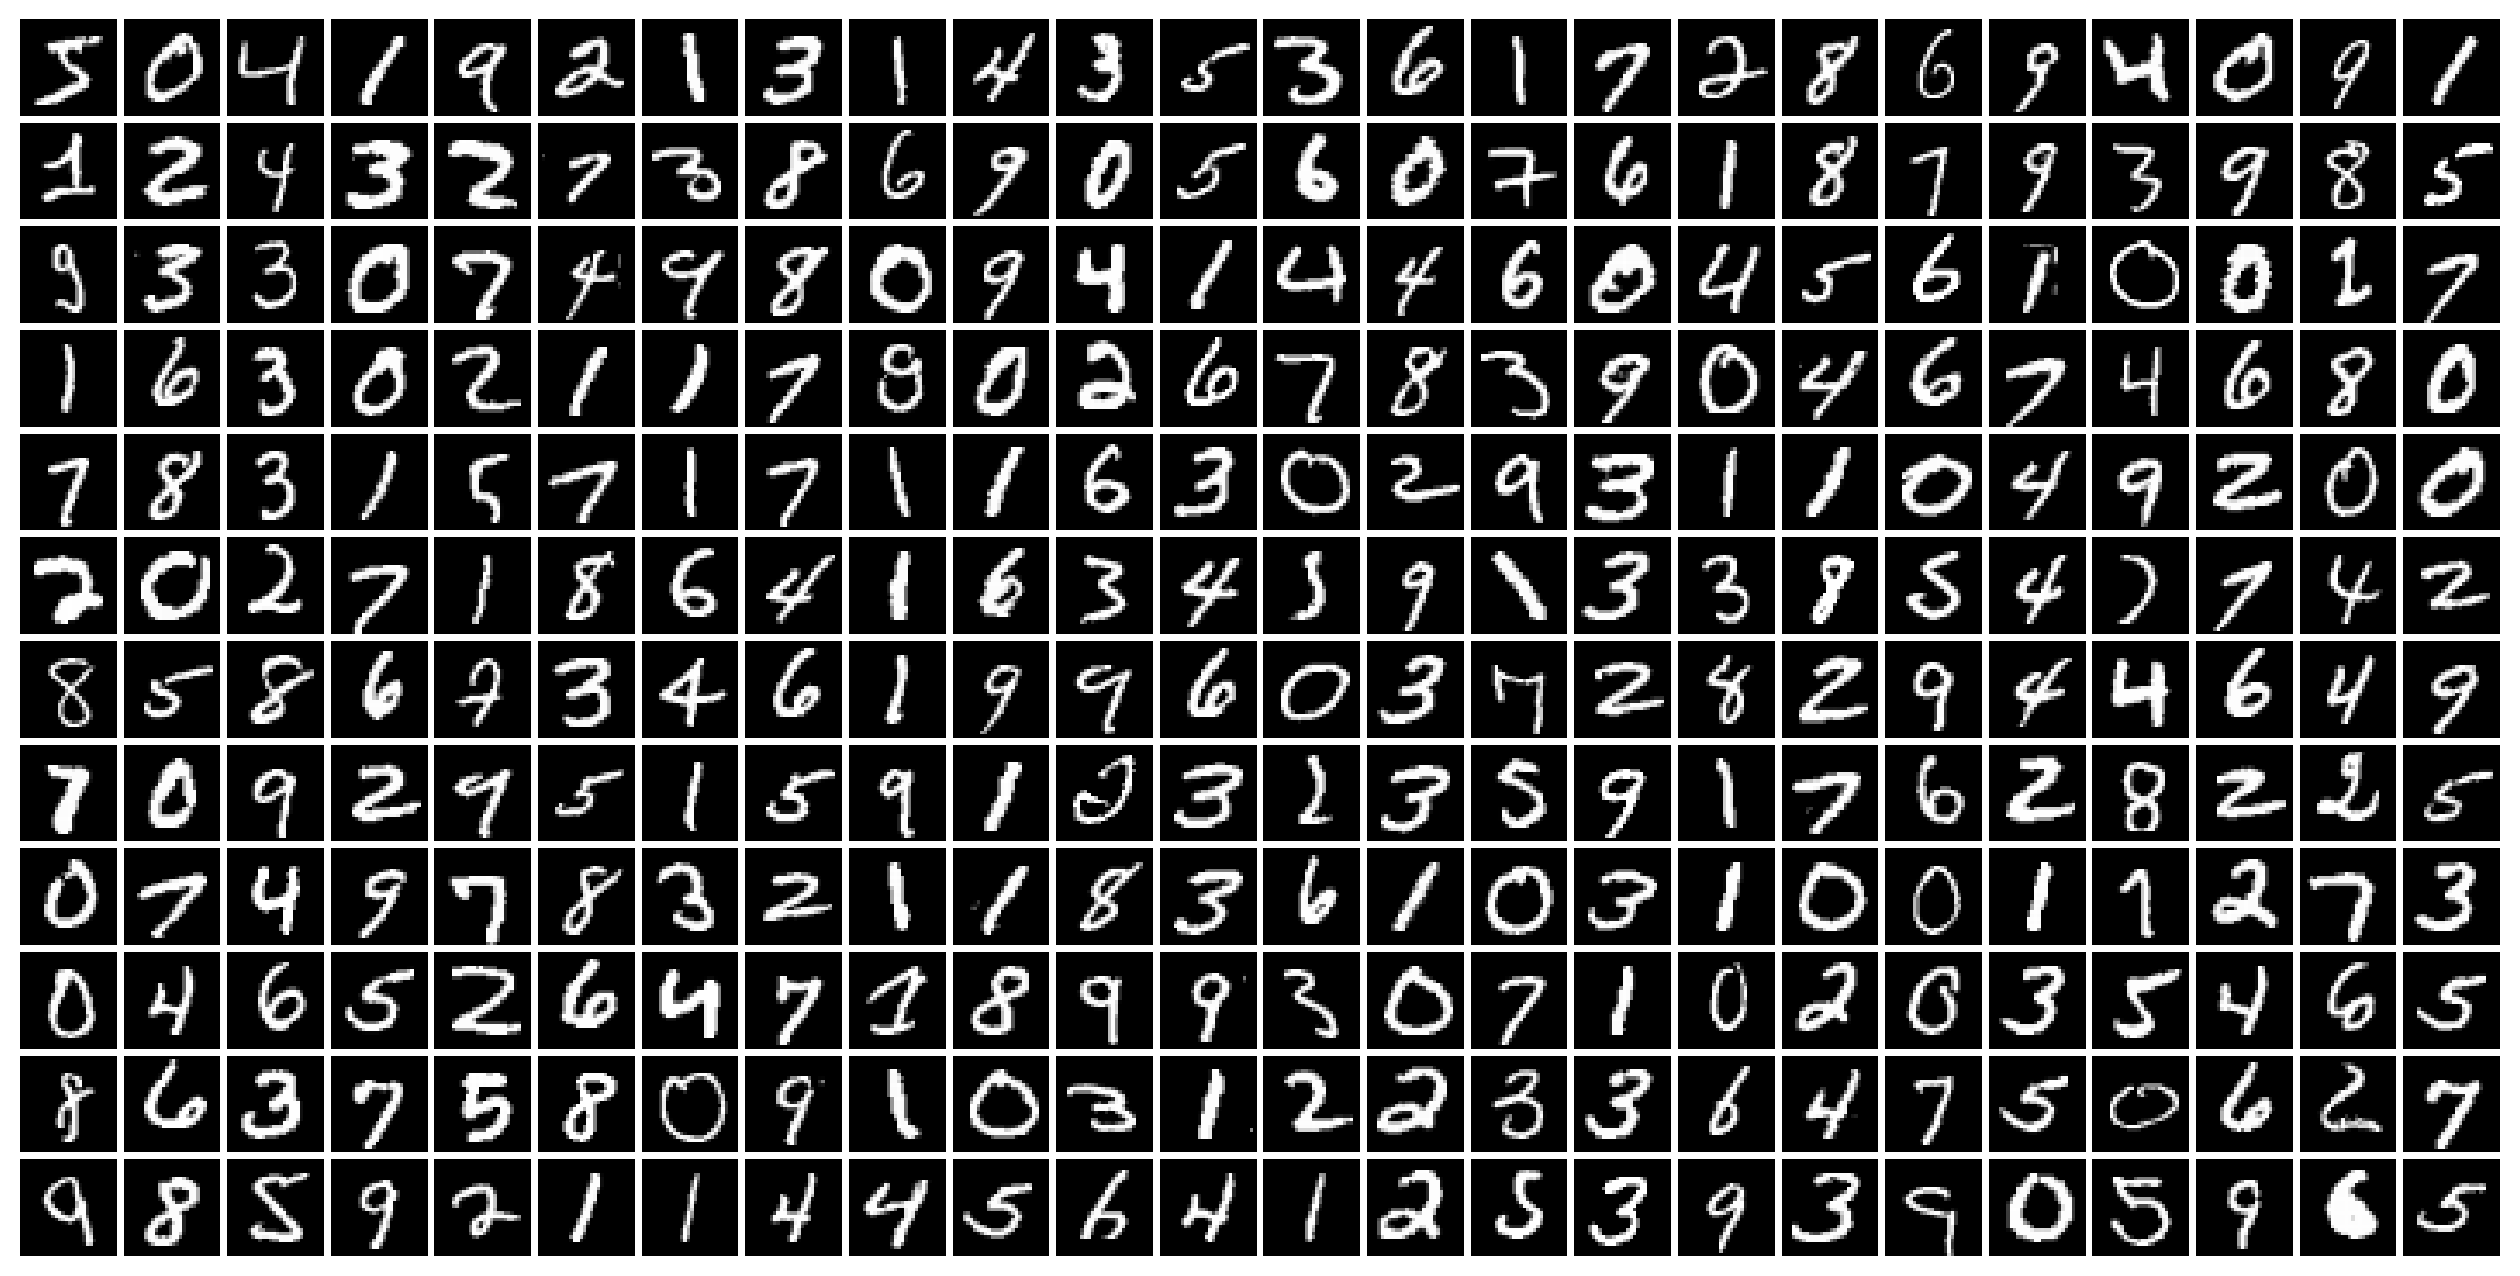

In [17]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

# Network layers

We define three types of layers: densely connected layer (```Dense```), convolutional layer (```Conv2D```) and non-linearity (```Nonlinear```). Each layer supports two operations:

- signal propagation: ```forward```
- error backpropagation: ```backward```

```backward``` operation backpropagates the delta and updates layer weights and biases.

Weights are initialized with "variance scaling" method (also known as "He initialization"). This initialization was proposed together with residual networks and is appropriate for networks with ReLU activations. Source: https://arxiv.org/pdf/1502.01852v1.pdf

**Note that in this lab we have separate vectors for biases.**

In [18]:
class Layer(ABC):
    """
    Interface for any differentiable parametrized tensor function with parameters `θ` that takes a
    single tensor `x` and returns a single tensor `y = Layer(x; θ)`.
    """

    # Outputs of the layer after forward pass
    y: Optional[NDArray]

    @abstractmethod
    def reset(self):
        """Initialize the layer."""
        raise NotImplementedError

    @abstractmethod
    def forward(self, x: NDArray, training: bool) -> NDArray:
        """Propagate the input `x` forward through the layer and save the output in `self.y`."""
        raise NotImplementedError

    @abstractmethod
    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        """
        Given layer input `x` and ∂Loss/∂y (`grad_y`)
            * compute ∂Loss/∂x and ∂Loss/∂θ (where θ are the layer's params);
            * update parameters using momentum SGD;
            * return ∂Loss/∂x;

        NOTE: We assume that the layers are connected in a simple path (i.e. the computation graph
        is linear) and thus we don't have to keep and accumulate the gradients ∂Loss/∂y in the layer
        itself, but can instead just dynamically pass ∂Loss/∂y while traversing this linear
        computation graph.
        """
        raise NotImplementedError

In [19]:
class Sequential(Layer):
    def __init__(self, *layers: Layer):
        self.layers: tuple[Layer, ...] = layers
        self.reset()

    def reset(self):
        self.y: Optional[NDArray] = None
        for layer in self.layers:
            layer.reset()

    def forward(self, x: NDArray, training: bool) -> NDArray:
        for layer in self.layers:
            x = layer.forward(x, training)
        self.y = x
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        for i in reversed(range(len(self.layers))):
            # Get input to the i-th layer i.e. output of the (i-1)-th layer (or `x` if i=0)
            y_prev = self.layers[i - 1].y if i > 0 else x
            # Propagate the ∂Loss/∂y backward through layer `i` and update params
            grad_y = self.layers[i].backward(y_prev, grad_y)
        return grad_y

### Non-linearity

In [ ]:
class ReLU(Layer):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = np.maximum(0, x)
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # Compute ∂Loss/∂x
        grad_x = grad_y * (x > 0).astype(np.float32)
        # Propagate ∂Loss/∂x backward
        return grad_x

### Densly connected layer

Implement missing parts in the ```backward``` method. Remember that the biases are kept in a separate vector.

In [21]:
class Linear(Layer):
    def __init__(
        self,
        vsize: int,
        hsize: int,
        lr: float,
        momentum: float,
        l2_penalty: Optional[float],
        weight_limit: Optional[float],
        init_method: Literal["Xavier", "He"],
    ):
        self.vsize: int = vsize
        self.hsize: int = hsize
        self.lr: float = lr
        self.momentum: float = momentum
        self.l2_penalty: Optional[float] = l2_penalty
        self.weight_limit: Optional[float] = weight_limit
        self.init_method: Literal["Xavier", "He"] = init_method
        self.reset()

    def reset(self):
        # Weights initialization
        match self.init_method:
            case "Xavier":
                scale = np.sqrt(6 / (self.vsize + self.hsize))
                self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case "He":
                scale = np.sqrt(4 / (self.vsize + self.hsize))
                self.w = np.random.normal(0, scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case _:
                raise ValueError(f"Unrecognised {self.init_method=}")

        # Bias initialization
        self.b = zeros(self.hsize)

        # Velocity (momentum) tensors initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.hsize)

        # Outputs
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = self.b + x @ self.w
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # Compute ∂Loss/∂x
        grad_x = grad_y @ self.w.T

        # Compute  ∂Loss/∂w and ∂Loss/∂b
        grad_w = x.T @ grad_y
        grad_b = grad_y.sum(axis=0)

        # Apply L2 regularization
        if self.l2_penalty:
            grad_w += self.l2_penalty * self.w

        # Update params
        self.m_w = self.momentum * self.m_w - self.lr * grad_w
        self.m_b = self.momentum * self.m_b - self.lr * grad_b

        self.w += self.m_w
        self.b += self.m_b

        # Apply weight limit normalization
        if self.weight_limit:
            self.w = limit_weights(self.w, self.weight_limit)

        # Propagate ∂Loss/∂x backward
        return grad_x

## Convolutional layers

We implement the convolution operation as a simple matrix multiplication. Essentially, convolution is a dot product between the kernel and the receptive fields (local regions of the input image). Therefore:
- We can rearrange the input volume into a matrix $\mathbf{X}$, in which each column is a receptive field reshaped to a vector. The number of columns in this matrix is equal to the number of receptive fields in an image multiplied by the number of input images (batch size).
- Next, we can reshape the convolution kernel into a vector. Note, however, that a convolutional layer has many kernels: the number of kernels is equal to the number of output channels. We can assemble these kernels into a matrix $\mathbf{K}$, in which each row is one kernel (reshaped to a vector).
- Once we have matrices $\mathbf{X}$ and $\mathbf{K}$, calculating the convolution is as simple as taking a matrix multiplication $\mathbf{KX}$.

A very important property of this implementation is that the convolution is expressed as a matrix multiplication. This is the same basic operation that is used in densely connected layers. This means that backpropagation equations from a simple MLPs also holds for this implementation of a convolutional layer. Matrix $\mathbf{X}$ is the equivalent of the visible layer and matrix $\mathbf{K}$ is the equivalent of the weight matrix.

Important notes:
- The rearrangements of the input volume into a matrix is implemented by ```im2col``` function.
- During backpropagation we need to perform an operation inverse to ```im2col```. Specifically, we need to “collapse” deltas from a matrix into a volume with shape equal to the shape of the input. This inverse operation is implemented by ```col2im``` function.
- Kernels in ```Conv2D``` are always kept as a matrix, where each row is a kernel for one output channel.
- Convolution layer has no activation function (or, equivalently, has an identify activation function). Nonlinear activations are implemented by a separate layer (```Nonlinear``` layer). Therefore, we can disregard activation function (and its derivative) when implementing error backpropagation in ```Conv2D```.
- We have a separate vector $\mathbf{B}$ for biases. Our expression for convolution is therefore: $\mathbf{KX} + \mathbf{B}$. Note that biases are shared between receptive fields (vector $\mathbf{B}$ is broadcasted to the shape of $\mathbf{KX}$). See implementation of ```Dense``` layer for hints about proper implementation of biases in forward/backward pass.

You can find more information about implementing convolution via ```im2col```/```col2im``` here:
* http://cs231n.stanford.edu/slides/2016/winter1516_lecture11.pdf
* http://cs231n.github.io/convolutional-networks/

### 2D convolution

Implement missing parts in the ```forward``` and ```backward``` methods.  Remember that the biases are kept in a separate vector.

In [22]:
class Conv2D(Layer):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int | tuple[int, int],
        strides: int | tuple[int, int],
        padding: int | tuple[int, int],
        lr: float,
        momentum: float,
        init_method: Literal["Xavier", "He"],
    ):
        self.in_channels: int = in_channels
        self.out_channels: int = out_channels
        self.kernel_size: tuple[int, int] = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.strides: tuple[int, int] = (strides, strides) if isinstance(strides, int) else strides
        self.padding: tuple[int, int] = (padding, padding) if isinstance(padding, int) else padding

        self.lr: float = lr
        self.momentum: float = momentum
        self.init_method: Literal["Xavier", "He"] = init_method

        self.reset()

    def reset(self):
        # Weights initialization
        nrow = self.out_channels
        ncol = self.in_channels * self.kernel_size[0] * self.kernel_size[1]

        match self.init_method:
            case "Xavier":
                scale = np.sqrt(6 / (nrow + ncol))
                self.w = np.random.uniform(-scale, +scale, size=(nrow, ncol)).astype(np.float32)
            case "He":
                scale = np.sqrt(4 / (nrow + ncol))
                self.w = np.random.normal(0, scale, size=(nrow, ncol)).astype(np.float32)
            case _:
                raise ValueError(f"Unrecognised {self.init_method=}")

        # Bias initialization
        eps = 1e-2  # Initialize biases to small positive values (for ReLU)
        self.b = zeros(self.out_channels, 1) + eps

        # Velocity (momentum) tensors initialization
        self.m_w = zeros(nrow, ncol)
        self.m_b = zeros(nrow, 1)

        # Outputs
        self.y: Optional[NDArray] = None

        # Cached indices for the im2col transformation
        self.indices: Optional[NDArray] = None
        # Cached input after padding and im2col transformation
        self.xcol: Optional[NDArray] = None
        # Shape of the last propagated tensor
        self.dims: Optional[tuple[int, int, int, int]] = None

    def _pad(self, x: NDArray) -> NDArray:
        assert len(x.shape) == 4
        pad_h, pad_w = self.padding
        return np.pad(x, pad_width=[(0, 0), (0, 0), (pad_h, pad_h), (pad_w, pad_w)])

    def _unpad(self, x: NDArray) -> NDArray:
        assert len(x.shape) == 4
        *_, H, W = x.shape
        pad_h, pad_w = self.padding
        return x[:, :, pad_h : H - pad_h, pad_w : W - pad_w]

    def forward(self, x: NDArray, training: bool) -> NDArray:
        assert len(x.shape) == 4
        assert x.shape[1] == self.in_channels

        B, C_in, H_in, W_in = x.shape
        H_out = int(1 + (H_in + 2 * self.padding[0] - self.kernel_size[0]) / self.strides[0])
        W_out = int(1 + (W_in + 2 * self.padding[1] - self.kernel_size[1]) / self.strides[1])

        if self.dims != x.shape:
            use_cached_indices = False
            self.dims = x.shape
        else:
            use_cached_indices = True

        # Apply padding transformation
        x = self._pad(x)  # (B, C_in, H_in + 2*pad_h, W_in + 2*pad_w)

        # Compute indices for im2col transformation
        if not use_cached_indices:
            idx_c, idx_h_ker, idx_w_ker = np.indices((C_in, *self.kernel_size)).reshape(3, -1)
            idx_h_out, idx_w_out = np.indices((H_out, W_out)).reshape(2, -1)

            idx_b = np.arange(B).reshape(-1, 1, 1)
            idx_c = idx_c.reshape(-1, 1)
            idx_h = idx_h_ker.reshape(-1, 1) + self.strides[0] * idx_h_out
            idx_w = idx_w_ker.reshape(-1, 1) + self.strides[1] * idx_w_out

            multi_index = (idx_b, idx_c, idx_h, idx_w)
            self.indices = np.ravel_multi_index(multi_index, dims=x.shape)  # (B, C_in * H_ker * W_ker, H_out * W_out)
            self.indices = self.indices.transpose(1, 0, 2)  # (C_in * H_ker * W_ker, B, H_out * W_out)
            self.indices = self.indices.reshape(-1, B * H_out * W_out)  # (C_in * H_ker * W_ker, B * H_out * W_out)

        # Apply im2col transformation
        x = self.xcol = np.take(x, self.indices)  # (C_in * H_ker * W_ker, B * H_out * W_out)

        # Apply affine transformation
        x = self.b + self.w @ x  # (C_out, B * H_out * W_ou)

        # Reshape
        x = x.reshape(-1, B, H_out, W_out)  # (C_out, B, H_out * W_out)
        x = x.transpose(1, 0, 2, 3)  # (B, C_out, H_out, W_out)
        self.y = x

        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        assert len(grad_y.shape) == 4
        assert len(x.shape) == 4
        assert x.shape[1] == self.in_channels
        assert grad_y.shape[1] == self.out_channels

        B, C_in, H_in, W_in = x.shape
        H_out = int(1 + (H_in + 2 * self.padding[0] - self.kernel_size[0]) / self.strides[0])
        W_out = int(1 + (W_in + 2 * self.padding[1] - self.kernel_size[1]) / self.strides[1])

        # --- Compute ∂Loss/∂x, ∂Loss/∂w and ∂Loss/∂b

        # Backpropagate through reshape operations
        grad_y = grad_y.transpose(1, 0, 2, 3)  # (C_out, B, H_out, W_out)
        grad_y = grad_y.reshape(-1, B * H_out * W_out)  # (C_out, B * H_out * W_out)

        # Backpropagate through affine transformation
        x = self.xcol  # (C_in * H_ker * W_ker, B * H_out * W_out)

        grad_w = grad_y @ x.T
        grad_b = grad_y.sum(axis=1, keepdims=True)
        grad_y = self.w.T @ grad_y  # (C_in * H_ker * W_ker, B * H_out * W_out)

        # Backpropagate through im2col operation
        dims = (B, C_in, H_in + 2 * self.padding[0], W_in + 2 * self.padding[1])
        grad_x = zeros(*dims).reshape(-1)

        for idx, val in zip(self.indices, grad_y):
            grad_x[idx] += val

        grad_x = grad_x.reshape(dims)

        # Backpropagate through padding operation
        grad_x = self._unpad(grad_x)

        # --- Update params
        self.m_w = self.momentum * self.m_w - self.lr * grad_w
        self.m_b = self.momentum * self.m_b - self.lr * grad_b

        self.w += self.m_w
        self.b += self.m_b

        # Propagate ∂Loss/∂x backward
        return grad_x

In [23]:
class Flatten(Layer):
    def __init__(self, start_dim: int = 1):
        self.start_dim: int = start_dim
        self.reset()

    def reset(self):
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = x.reshape(*x.shape[: self.start_dim], -1)
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # Compute ∂Loss/∂x
        grad_x = grad_y.reshape(x.shape)
        # Propagate ∂Loss/∂x backward
        return grad_x

### Model training

In [ ]:
def train(model: Sequential, X_train: NDArray, y_train: NDArray, batch_size: int):
    batches_limit = X_train.shape[0] // batch_size
    batched_data = chunks(X_train, batch_size)
    batched_labels = chunks(y_train, batch_size)

    for batch_idx, (batch, batch_labels) in enumerate(zip(batched_data, batched_labels)):
        logits = model.forward(batch, training=True)
        grad_y = 1 / len(batch) * (softmax(logits) - batch_labels)
        model.backward(batch, grad_y)

        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")

# MNIST digits classification

In [ ]:
def classify(model: Sequential, batch: NDArray) -> NDArray:
    logits = np.concatenate([model.forward(mini_batch, training=False) for mini_batch in chunks(batch, 128)])
    return np.argmax(logits, axis=1)


def run_training(
    model: Sequential,
    X_train: NDArray,
    y_train: NDArray,
    X_valid: NDArray,
    y_valid: NDArray,
    batch_size: int,
    num_epochs: int,
):
    for epoch in range(num_epochs):
        print("Epoch {}:".format(epoch + 1), end="\t")

        # Training phase
        t_elapsed = time.perf_counter()
        train(model, X_train, y_train, batch_size)
        t_elapsed = time.perf_counter() - t_elapsed

        # Validation phase
        predictions = classify(model, X_valid)
        accuracy = 1 / len(y_valid) * np.sum(predictions == y_valid)
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2%}".format(t_elapsed, accuracy))

    print("Training finished!")

In [26]:
DATASET_SIZE = 10_000  # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = mnist_train_images[:DATASET_SIZE]
mnist_train_images = mnist_train_images.reshape(-1, 1, DIGIT_SIZE, DIGIT_SIZE)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = mnist_test_images.reshape(-1, 1, DIGIT_SIZE, DIGIT_SIZE)

mnist_test_labels = mnist.test_labels()

In [ ]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

params = {
    "linear": {
        "lr": 0.01,
        "momentum": 0.9,
        "init_method": "He",
        "l2_penalty": None,
        "weight_limit": None,
    },
    "conv": {
        "lr": 0.02,
        "momentum": 0.9,
        "init_method": "He",
    },
}
model = Sequential(
    Conv2D(1, 2, 3, 1, 1, **params["conv"]),
    ReLU(),
    Conv2D(2, 2, 2, 2, 0, **params["conv"]),
    ReLU(),
    Conv2D(2, 4, 3, 1, 1, **params["conv"]),
    ReLU(),
    Conv2D(4, 4, 2, 2, 0, **params["conv"]),
    ReLU(),
    Conv2D(4, 32, 3, 1, 1, **params["conv"]),
    Flatten(1),
    ReLU(),
    Linear(32 * 7 * 7, 10, **params["linear"]),
)

run_training(
    model,
    mnist_train_images,
    mnist_train_labels,
    mnist_test_images,
    mnist_test_labels,
    BATCH_SIZE,
    EPOCHS_COUNT,
)

Epoch 1:	########################################	elapsed: 1.68s, accuracy: 92.28%
Epoch 2:	########################################	elapsed: 2.75s, accuracy: 93.32%
Epoch 3:	########################################	elapsed: 2.63s, accuracy: 93.71%
Epoch 4:	########################################	elapsed: 2.51s, accuracy: 94.24%
Epoch 5:	########################################	elapsed: 2.73s, accuracy: 95.13%
Epoch 6:	########################################	elapsed: 3.52s, accuracy: 95.54%
Epoch 7:	########################################	elapsed: 3.08s, accuracy: 95.59%
Epoch 8:	########################################	elapsed: 2.93s, accuracy: 94.77%
Epoch 9:	########################################	elapsed: 2.90s, accuracy: 94.74%
Epoch 10:	########################################	elapsed: 2.77s, accuracy: 95.43%
Epoch 11:	########################################	elapsed: 3.26s, accuracy: 96.06%
Epoch 12:	########################################	elapsed: 3.33s, accuracy: 96.13%
E